# Replicate figure 4b from Nature Methods, Li etc. al. 

Here I attempt to replicate figure 4b from the below paper.  

https://www.nature.com/articles/s41592-022-01652-7?utm_source=twitter&utm_medium=social&utm_campaign=nmeth

I did not run their neural network (RLN), but simply ran a non-circulant classical Richardson Lucy with theoretical PSF assuming slight spherical aberration and compared it to the figure they provided


## Create a decon conda environment

In this environment we will install some tools we need for decon, this includes Jupyter noteook, clij2fft for non-circulant Richardson Lucy, devbio version of Napari for visualization, sdeconv for theoretical PSF, tnia-python for XYZ projected figures in the notebook. 

    conda create --name decon-env python=3.9
    conda activate decon-env
    pip install devbio-napari
    pip install git+https://github.com/True-North-Intelligent-Algorithms/tnia-python
    pip install napari-sdeconv
    pip install --index-url https://test.pypi.org/simple/ --no-deps clij2-fft
    
    
The above installations should be adequate, however if there are opencl errors or the deconvolution fails with error code -1001 try to install pyopencl with conda

    conda install -c conda-forge pyopencl==2021.2.6 hdbscan numba=0.55.1
    
If there is an sdeconv error when generating theoretical PSFs try installing the fftw library with conda

    conda install -c conda-forge fftw
    
Mac-users may also need to install this:

    conda install -c conda-forge ocl_icd_wrapper_apple

Linux users may also need to install this:

    conda install -c conda-forge ocl-icd-system


## Open test images

1.  Get images from here https://www.dropbox.com/scl/fo/ir7g1bz4w0bbjbskbq5ng/h?dl=0&rlkey=zdbven69fvd60za8wt49fd0w9.  The images for this example are in the 'deconvolution/deep-learning folder if you do not want to download the entire image set.  (images were originally from here https://www.nature.com/articles/s41592-022-01652-7?utm_source=twitter&utm_medium=social&utm_campaign=nmeth#data-availability)

2.  If trying to run this notebook on your own machine obviously change the paths to where you put the figures

(61, 1024, 1024)


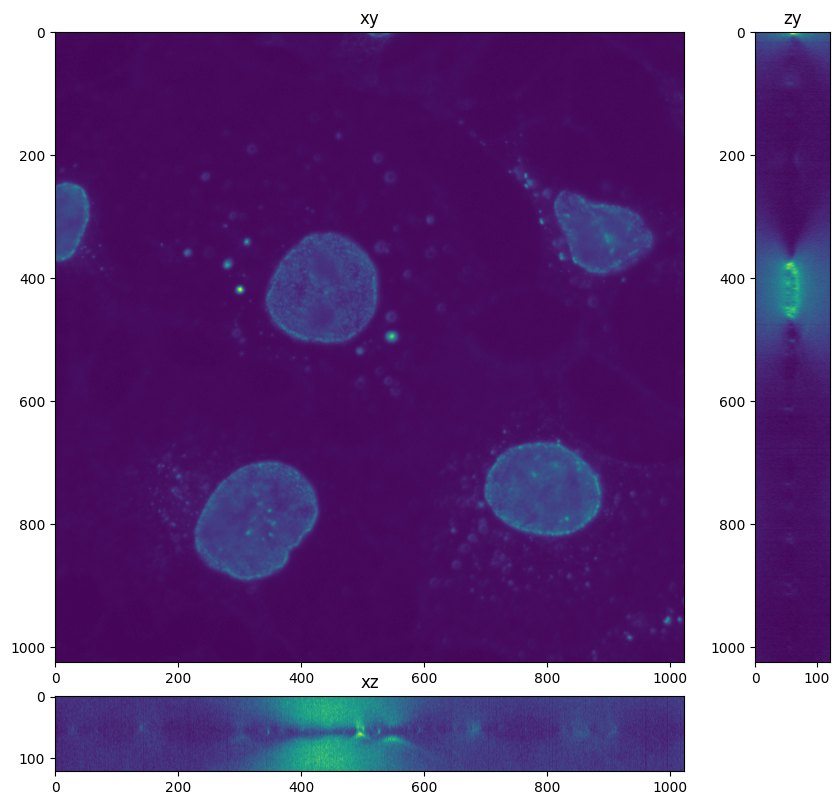

In [119]:
from skimage.io import imread
from tnia.plotting.projections import show_xyz_max, show_xyz_slice, show_xyz_slice_center, show_xyz_max
import numpy as np
import sys

if sys.platform=='linux':
    im_path=r"/home/bnorthan/Images/tnia-python-images/deconvolution/deep-learning/Figure4b/Figure4_training&test/test dataset/"
    rln_path=r"/home/bnorthan/Images/tnia-python-images/deconvolution/deep-learning/Figure4b/Figure4_training&test/RLN_output/"
else:
    im_path=r"D:\images\tnia-python-images\deconvolution\deep-learning\Figure4b\Figure4_training&test\test dataset\\"
    rln_path=r"D:\images\tnia-python-images\deconvolution\deep-learning\Figure4b\Figure4_training&test\RLN_output\\"

im_name='NPC-1.tif'
rln_name='RLN_NPC-1.tif'

im=imread(im_path+im_name)
rln=imread(rln_path+rln_name)
rln=np.squeeze(rln)

im=im.astype('float32')
print(im.shape)

fig=show_xyz_slice_center(im,1,2)

## Define an ROI to work with

We try to use the same ROI as in the paper (also define a second ROI which allows us to test quickly with a very small particle)

(61, 60, 40)


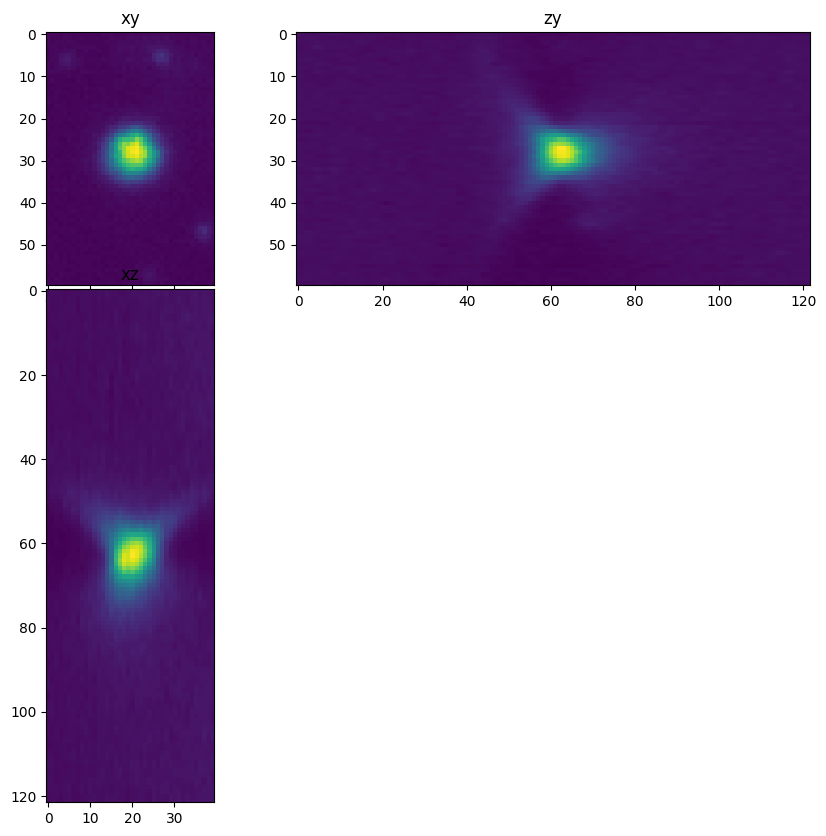

In [120]:
#roi=np.s_[:, 300:580, 240:600]
roi=np.s_[15:46, 390:450, 270:330]

#roi=np.s_[26:36, 170:210, 78:110]

#roi=np.s_[24:36, 470:510, 318:350]
roi=np.s_[:, 390:450, 280:320]

im=im[roi]
im=np.flip(im,0)
rln=rln[roi]
rln=np.flip(rln,0)

fig=show_xyz_slice_center(im,1,2)
print(im.shape)

## Create PSF

From the paper xy voxel size is 0.101, NA 1.5, I assume a biological object with RI ~ 1.33, and calculate PSF at the center of the z range (so that the slight spherical aberration will be in the PSF). 

In [121]:
30*.25

7.5

sdeconv 1.x.x detected
sdeconv 1.x.x detected
sdeconv 1.x.x detected
sdeconv 1.x.x detected
sdeconv 1.x.x detected
sdeconv 1.x.x detected


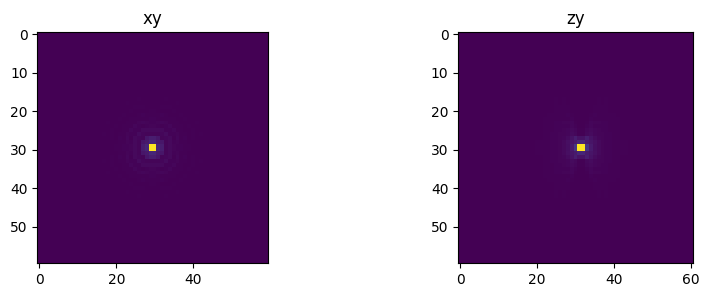

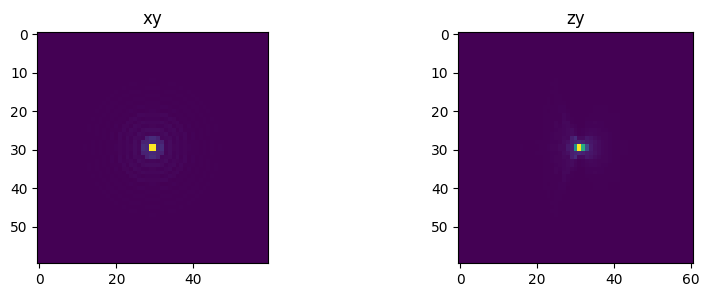

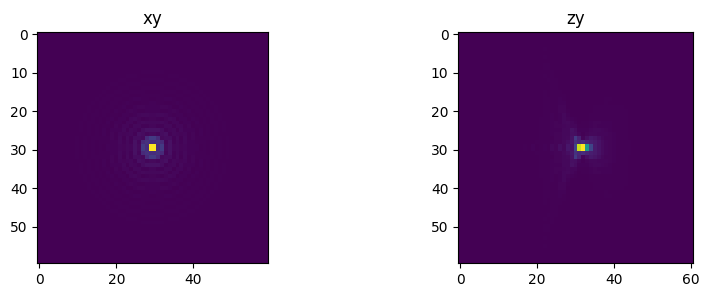

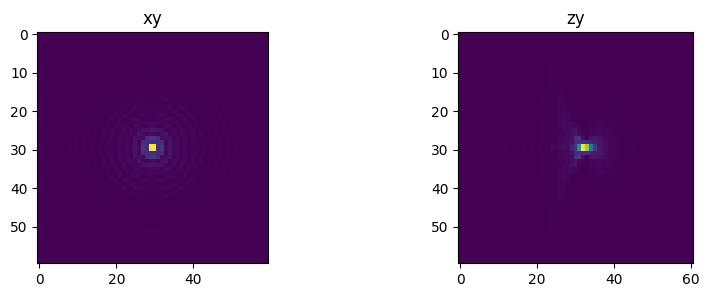

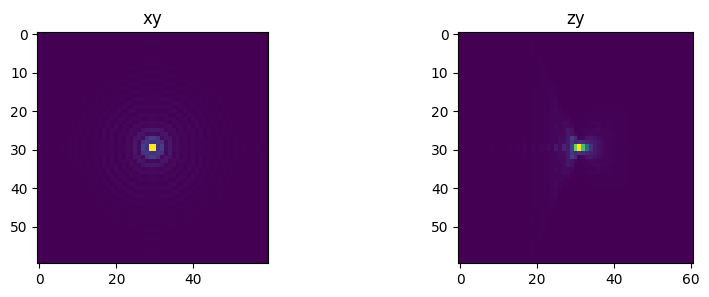

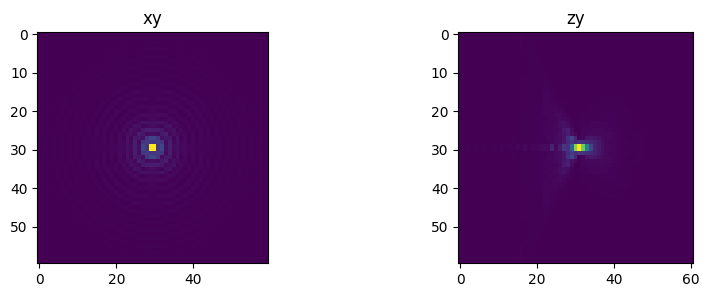

In [150]:
from tnia.deconvolution.psfs import gibson_lanni_3D
from tnia.plotting.projections import show_xy_zy_max, show_xy_zy_slice_center
from tnia.deconvolution.psfs import recenter_psf_axial

x_voxel_size = 0.101
z_voxel_size=.3

xy_psf_dim=60
z_psf_dim=200

NA=1.4
ni=1.5
ns=1.4
d=5
wave=0.45

ds=[0,3,5,7,9,15]

psfs=[]
for d in ds:
    psf  = gibson_lanni_3D(NA, ni, ns, x_voxel_size, z_voxel_size, xy_psf_dim, z_psf_dim, d, wave)
    psf=recenter_psf_axial(psf, 61)
    fig = show_xy_zy_max(psf)
    psfs.append(psf)

## Deconvolve using non-circulant Richardson Lucy

get lib
get lib
get lib
get lib
get lib
get lib


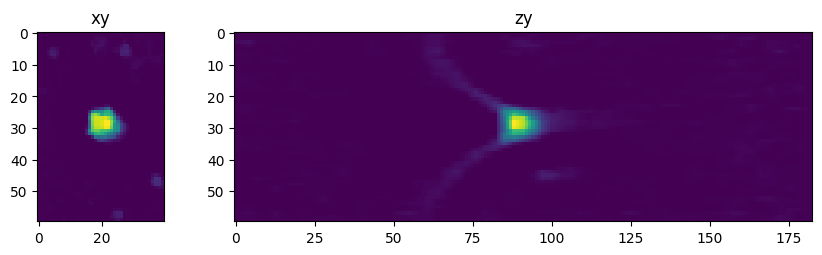

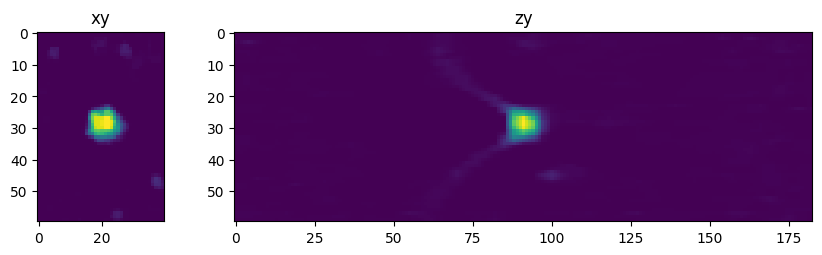

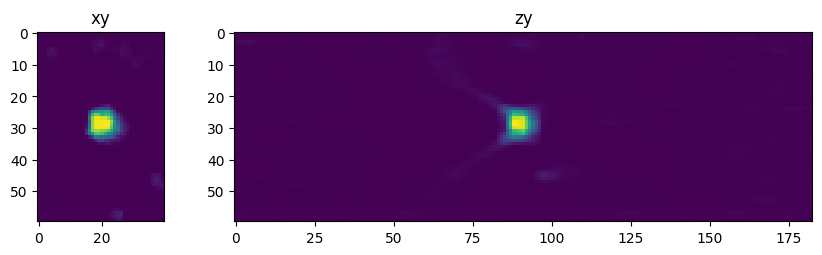

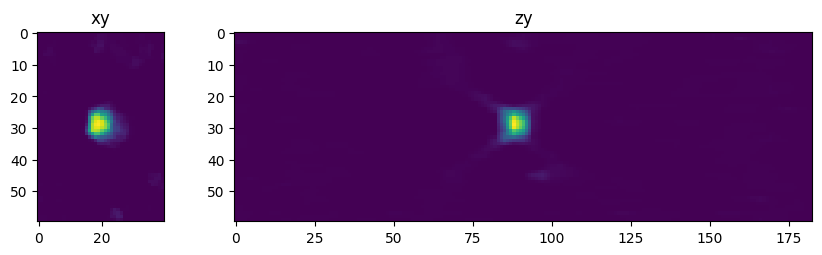

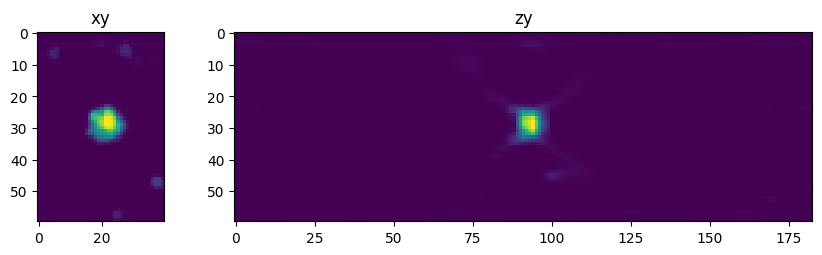

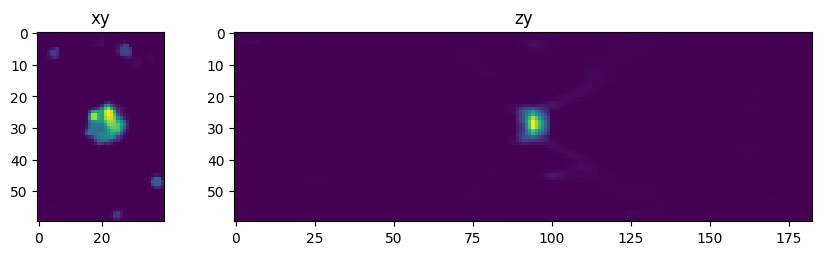

In [151]:
from clij2fft.richardson_lucy import richardson_lucy_nc
regularization_factor=0.0005

decons=[]

for psf in psfs:
    decon = richardson_lucy_nc(im, psf, 1000, regularization_factor)
    decons.append(decon)
    fig = show_xy_zy_slice_center(decon,1,3)

In [128]:
im.shape

(61, 60, 40)

Text(0.5, 0.98, 'Richardson Lucy Network')

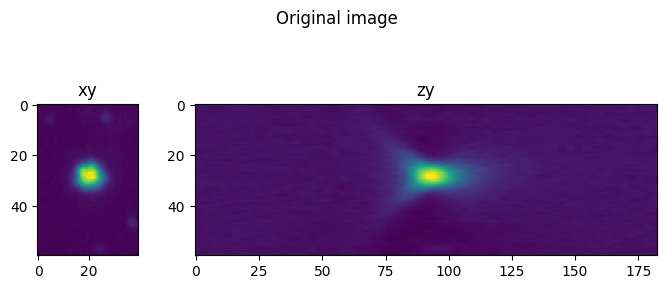

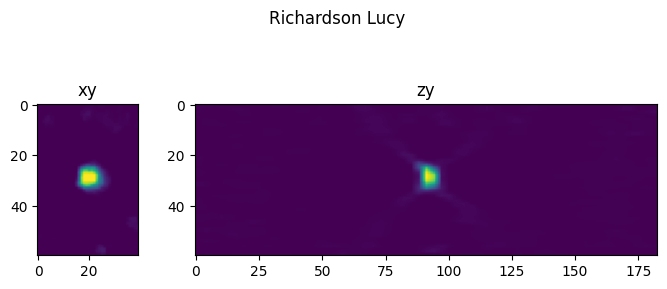

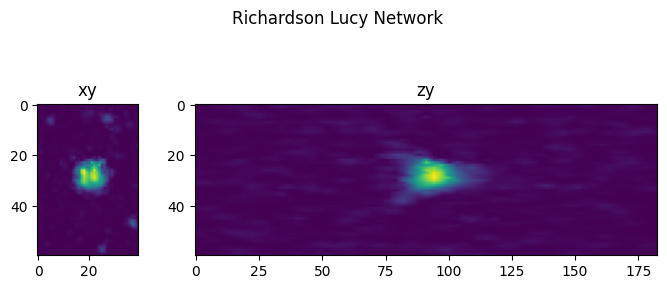

In [155]:
from tnia.plotting.projections import show_xy_zy_slice
fig=show_xy_zy_slice(im, 23,34,31,1,3, figsize=(8,3.5))
#fig.get_axes()[0].set_title('Original image')
fig.suptitle('Original image')

#fig.suptitle('Original Image')
fig=show_xy_zy_slice(decons[4], 23,34,31,1,3, figsize=(8,3.5))
fig.suptitle('Richardson Lucy')

fig=show_xy_zy_slice(rln, 23,34,31,1,3, figsize=(8,3.5))
fig.suptitle('Richardson Lucy Network')

## Visualize in Napari

In [ ]:
import napari
viewer=napari.Viewer()

viewer.add_image(im, scale=(2,1,1))
viewer.add_image(im_decon, scale=(2,1,1))
viewer.add_image(rln, scale=(2,1,1))


In [ ]:
from tnia.plotting.projections import show_xy_zy_slice_center
#roi=np.s_[26:36, 170:210, 78:110]
roi=np.s_[15:46, 100:140, 40:80]

im_=im[roi]
rln_=rln[roi]
decon_=im_decon[roi]

fig=show_xy_zy_slice_center(im_,1,2,figsize=(5,7))
fig.get_axes()[0].set_title('Raw')

fig=show_xy_zy_slice_center(decon_,1,2,figsize=(5,7))
fig.get_axes()[0].set_title('Richardson Lucy')

fig=show_xy_zy_slice_center(rln_,1,2,figsize=(5,7))
fig.get_axes()[0].set_title('Richardson Lucy Network')

In [ ]:
import napari
viewer=napari.Viewer()

viewer.add_image(im_, scale=(2,1,1))
viewer.add_image(decon_, scale=(2,1,1))
viewer.add_image(rln_, scale=(2,1,1))